In [242]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import sys
import glob
import sys
import os
import pickle
import tqdm

import shield_optimization as so

In [243]:
plt.style.use('tableau-colorblind10')
plt.style.use('../figures/style.mplstyle')

In [245]:
E_tot = 8.4736 # MeV
M = (29*931.5 - 21.895) # mass of Si29 (MeV)
E1 = -M + np.sqrt(M**2 + 2*M*E_tot)
E1_lm = E1**2/2/M
hm = ('highmass1', 'highmass2')
lm = 'lowmass'
detectors = ('highmass1', 'highmass2', 'lowmass')

In [246]:
def identify_deposit(PName):
    if PName in 'e- e+ gamma proton alpha deuteron triton':
        return 0
    elif PName in 'P31 ' or PName[:2] in 'Si Al Mg Ge Ga As Se Zn': 
        return 1
    else:
        raise Exception('unknown PName = ' + PName)


def yLind(Er):
    Er *= 1e3 # convert to keV from MeV
    Z = 28
    k = 0.15
    eps = 11.5*Er/np.cbrt(Z)**7
    g = 3*eps**0.15 + 0.7*eps**0.6 + eps
    Y = k*g/(1+k*g) # yield
    return Y 



def get_charge_histograms(rates, Ebins = None, Emin = 100e-6, Emax = 20, Nbins = 200, E_window = 0.1):
    # collect histograms of charge energy in hm1 and hm2, as well as histograms of charge energy in hm1 and hm2 WITH COINCIDENCES WITH lowmass
    # E_window = relative window for energies in lowmass detector to cut by (relative to signal peak = 8.4736 MeV)

    XR = -1
    ER = 0
    NR = 1

    Elow = (1-E_window)*E1_lm
    Ehigh = (1+E_window)*E1_lm
    # bounds of energy window in lowmass detector

    if Ebins == None:
        Ebins = np.linspace(Emin, Emax, Nbins+1, endpoint = True) # bin edges (MeV)
    else:
        Emin = Ebins[0]
        Emax = Ebins[-1]
        Nbins = Ebins.size - 1


    ROOT.TH1.AddDirectory(False)


    events = {meas: {det: ROOT.TH1D(
            det + '_all',
            det + ' all',
            Nbins, Ebins
            ) for det in detectors} for meas in rates.measurements_list}
    
    coincs = {meas: {det: ROOT.TH1D(
            det + '_coinc',
            det + ' coincidence events',
            Nbins, Ebins
            ) for det in hm} for meas in rates.measurements_list}

    ecut = {meas: {det: ROOT.TH1D(
            det + '_coinc_energy_cut',
            det + ' coincidence events w/ energy cut',
            Nbins, Ebins
            ) for det in hm} for meas in rates.measurements_list}

    
    caps = {meas: {det: ROOT.TH1D(
            det + '_captures',
            det + ' postcapture events',
            Nbins, Ebins
            ) for det in hm} for meas in rates.measurements_list}


    if Nbins == 1:
        lm_evts_list = {det: [] for det in hm}
    
    for meas in rates.measurements_list:
        for det in hm:
            events[meas][det].Reset()
            coincs[meas][det].Reset()
            ecut[meas][det].Reset()
            caps[meas][det].Reset()


    for i in tqdm.trange(rates.N):

        meas = rates.measurements[i]

        tfile = ROOT.TFile.Open(rates.glob_list[i], 'READ')
        tree = tfile.Get('tree')

        last_event = -1
        energy = {det: 0. for det in detectors}

        for k in range(tree.GetEntries()):
            tree.GetEntry(k)

            EventNum = int(getattr(tree, 'EventNum'))
            #TrkNum = int(getattr(tree, 'TrkNum'))
            Edep = float(getattr(tree, 'Edep'))
            VolName = getattr(tree, 'VolName')
            PName = getattr(tree, 'PName')
            #ProcName = getattr(tree, 'ProcName')
            ParentVol = getattr(tree, 'ParentVol')
            IsCapture = bool(int(getattr(tree, 'IsCapture')))
            #KE = float(getattr(tree, 'KE'))
            #KE3 = float(getattr(tree, 'KE3'))
            #DepProc = getattr(tree, 'DepProc')
            #Time = float(getattr(tree, 'Time'))
            #X = float(getattr(tree, 'X'))
            #Y = float(getattr(tree, 'Y'))
            #Z = float(getattr(tree, 'Z'))

            if abs(EventNum - last_event) > 1e-6: # new event

                last_event = EventNum

                # process previous event
                for det in detectors:
                    if energy[det] > 0:
                        events[meas][det].Fill(energy[det])
                        if det in hm:
                            if energy[lm] > 0:
                                cprev = coincs[meas][det].GetBinContent(1)
                                coincs[meas][det].Fill(energy[det])
                                if energy[lm] > Elow and energy[lm] < Ehigh:
                                    ecut[meas][det].Fill(energy[det])
                                if Nbins == 1:
                                    cnew = coincs[meas][det].GetBinContent(1)
                                    if cnew > cprev:
                                        lm_evts_list[det].append(energy[lm])
                                if IsCapture:
                                    caps[meas][det].Fill(energy[det])

                energy = {det: 0. for det in detectors}


            # accumulate info from this event
            if Edep > 0:
                if VolName == 'lowmass':
                    energy[VolName] += Edep
                else:
                    DT = identify_deposit(PName)
                    if DT == ER:
                        Eq = Edep
                    elif DT == NR:
                        Eq = Edep*yLind(Edep)
                    energy[VolName] += Eq
            
            # end of loop over tree

        tfile.Close()
        # end of loop over files

    # convert ROOT TH1D's into dataframes
    df = {}
    for meas in rates.measurements_list:
        data_dict = {'E': Ebins}
        for dictionary in (events, coincs, ecut, caps):
            for det in dictionary[meas].keys():
                hist = dictionary[meas][det]
                name = hist.GetName()
                cts = np.zeros(Nbins+1)

                for i in range(1, Nbins+1):
                    cts[i-1] = hist.GetBinContent(i)

                data_dict[name] = cts

        df[meas] = pd.DataFrame.from_dict(data_dict)

    # end of function: return dataframe
    if Nbins == 1:
        return df, lm_evts_list
    else:
        return df


def get_all_histograms(rates, lm_cut, hm_cut):
    """
    rates - BackgroundRates object
    lm_cut - size of energy cut window in lowmass
    hm_cut - size of energy cut window in highmass

    function returns the following types of histogram for each detector:
        "all" - all events
        "coincidences" - all events in coincidence with another event in:
            lowmass (for highmass detectors)
            either one of the highmass detectors (for lowmass)
        "energy_cut" - all events in coincidence, where the coincident event is within the cut window for the other detector
    
    over each of the energy bins:
        "full_range" - full range, 200 bins
            100 eV to 20 MeV in highmass
            1 eV to 7 MeV in lowmass
        "cut_window" - range of energy cuts, 40 bins
            E1 +/- hm_cut/2 in highmass
            E1_lm +/- lm_cut/2 in lowmass
    """

    # recoil types
    XR = -1
    ER = 0
    NR = 1
    E1_hm = E1

    bg_window = 0.1
    meas = (20., 1.)

    lm = 'lowmass'
    hm1 = 'highmass1'
    hm2 = 'highmass2'
    detectors = (lm, hm1, hm2)
    hm = (hm1, hm2)

    # energy bins (MeV)
    Ebins_full_range_hm = np.linspace(100e-6, 20, 200, endpoint = True)
    Ebins_full_range_lm = np.linspace(1e-6, 8, 200, endpoint = True)

    Ebins_cut_window_hm = E1_hm + hm_cut*np.linspace(-0.5, 0.5, 16, endpoint = True)
    Ebins_cut_window_lm = E1_lm + lm_cut*np.linspace(-0.5, 0.5, 16, endpoint = True)


    lmlow = Ebins_cut_window_lm.min()
    lmhigh = Ebins_cut_window_lm.max()
    hmlow = Ebins_cut_window_hm.min()
    hmhigh = Ebins_cut_window_hm.max()
    

    bin_types = ('full_range', 'cut_window')

    Ebins_dict = {'lowmass': {
                'full_range': Ebins_full_range_lm,
                'cut_window': Ebins_cut_window_lm
            },
            'highmass1': {
                'full_range': Ebins_full_range_hm,
                'cut_window': Ebins_cut_window_hm
            }
    }
    Ebins_dict['highmass2'] = Ebins_dict['highmass1']

    hist_types = ('all', 'coincidences', 'energy_cut')
    all_hists = {}

    ROOT.TH1.AddDirectory(False)

    for hist_type in hist_types:
        all_hists[hist_type] = {}

        for det, bin_dict in Ebins_dict.items():
            all_hists[hist_type][det] = {}
            for bin_type, Ebins in bin_dict.items():
                all_hists[hist_type][det][bin_type] = ROOT.TH1D(
                    '_'.join([det, hist_type, bin_type]),
                    '_'.join([det, hist_type, bin_type]),
                    Ebins.size-1, 
                    Ebins
                )

    
    for hist_type in hist_types:
        for det in detectors:
            for bin_type in bin_types:
                all_hists[hist_type][det][bin_type].Reset()


    for i in tqdm.trange(rates.N):

        measi = rates.measurements[i]

        tfile = ROOT.TFile.Open(rates.glob_list[i], 'READ')
        tree = tfile.Get('tree')

        last_event = -1
        energy = {det: 0. for det in detectors}

        for k in range(tree.GetEntries()):
            tree.GetEntry(k)

            EventNum = int(getattr(tree, 'EventNum'))
            #TrkNum = int(getattr(tree, 'TrkNum'))
            Edep = float(getattr(tree, 'Edep'))
            VolName = getattr(tree, 'VolName')
            PName = getattr(tree, 'PName')
            #ProcName = getattr(tree, 'ProcName')
            ParentVol = getattr(tree, 'ParentVol')
            IsCapture = bool(int(getattr(tree, 'IsCapture')))
            #KE = float(getattr(tree, 'KE'))
            #KE3 = float(getattr(tree, 'KE3'))
            #DepProc = getattr(tree, 'DepProc')
            Time = float(getattr(tree, 'Time'))
            #X = float(getattr(tree, 'X'))
            #Y = float(getattr(tree, 'Y'))
            #Z = float(getattr(tree, 'Z'))

            if abs(EventNum - last_event) > 1e-6: # new event

                # process previous event
                for det in detectors:
                    if energy[det] > 0:
                        for b in bin_types:
                            all_hists['all'][det][b].Fill(energy[det])
                        if det == lm:
                            if (energy[hm1] > 0) or (energy[hm2] > 0):
                                for b in bin_types:
                                    all_hists['coincidences'][det][b].Fill(energy[det])
                                if (energy[hm1] > hmlow and energy[hm1] < hmhigh) or (energy[hm2] > hmlow and energy[hm2] < hmhigh):
                                    for b in bin_types:
                                        all_hists['energy_cut'][det][b].Fill(energy[det])
                                        if energy[lm] > lmlow and energy[lm] < lmhigh:
                                            print(rates.glob_list[i], last_event, det, file = open('ecut_evts.txt', 'a'))
                        else:
                            if energy[lm] > 0:
                                for b in bin_types:
                                    all_hists['coincidences'][det][b].Fill(energy[det])
                                if energy[lm] > lmlow and energy[lm] < lmhigh:
                                    for b in bin_types:
                                        all_hists['energy_cut'][det][b].Fill(energy[det])
                                        
                        

                energy = {det: 0. for det in detectors}
                last_event = EventNum


            # accumulate info from this event
            if (Edep > 0) and (Time < 1e9*360*24*365*100):
                if VolName == lm:
                    energy[VolName] += Edep
                else:
                    DT = identify_deposit(PName)
                    if DT == ER:
                        Eq = Edep
                    elif DT == NR:
                        Eq = Edep*yLind(Edep)
                    energy[VolName] += Eq
            
            # end of loop over tree

        tfile.Close()
        # end of loop over files

    # convert ROOT TH1D's into dataframes

    df_dict = {h: {} for h in hist_types}

    for hist_type in hist_types:
        for det in detectors:
            df_dict[hist_type][det] = {}
            for bin_type in bin_types:
                h = all_hists[hist_type][det][bin_type]
                Ebins = Ebins_dict[det][bin_type]
                Nbins = Ebins.size - 1
                cts = np.zeros(Nbins+1)
                for i in range(1, Nbins+1):
                    cts[i-1] = h.GetBinContent(i)
                

                df_dict[hist_type][det][bin_type] = pd.DataFrame.from_dict({'E': Ebins, h.GetName(): cts})

    return df_dict


class Counts:

    def __init__(self, match, Emin = 0.5e-6, Emax = 10, Nbins = 200, logbins = False, raw_data_dir = '../build/cap_sim/', save = True):

        self.raw_data_dir = raw_data_dir
        self.match = match
        self.Nprimaries = cap_primaries_dict[self.match]
        self.filenames = glob.glob(self.raw_data_dir+self.match)
        self.save = save

        self.Emin = Emin
        self.Emax = Emax
        self.Nbins = Nbins

        self.storage_dir = 'analysis_data/cap_sim_cts/'

        if logbins:
            self.Ebins = np.geomspace(Emin, Emax, Nbins+1, endpoint = False) 
        else:    
            self.Ebins = np.linspace(Emin, Emax, Nbins+1, endpoint = True) # bin edges (MeV)


        if self.save and self.match+'.txt' in os.listdir(self.storage_dir):
            
            with open(self.storage_dir + self.match + '.txt', 'rb') as file:
                self.cts = pickle.load(file)
            #self.cts = np.loadtxt(self.storage_dir + self.match+'.txt')
            self.Ebins = np.loadtxt(self.storage_dir + self.match + '_Ebins.txt')
            self.Nbins = len(self.Ebins)
            Emin = self.Ebins[0]
            Emax = self.Ebins[-1]

            print('loaded ' + self.match+'.txt')
        else:
            print('running get_gamma_deposit_spec()')
            self.cts = get_gamma_deposit_spec(self.filenames, self.Ebins)
            if self.save:
                with open(self.storage_dir + self.match + '.txt', 'wb') as file:
                    pickle.dump(self.cts, file)
                np.savetxt(self.storage_dir + self.match + '_Ebins.txt', self.Ebins)

        self.dE = (self.Ebins[1:] - self.Ebins[:-1]).mean()
        self.Emids = (self.Ebins[1:] + self.Ebins[:-1])/2# bin centers

        self.hm = self.cts['highmass1'] + self.cts['highmass2']

In [247]:
detectors = ('lowmass', 'highmass1', 'highmass2')
hm = ('highmass1', 'highmass2')
lm = 'lowmass'
meas = (20.,1.)

leadrates = so.BackgroundRates(match = 'Lead20.000000_PE1.000000_*_t*.root', Ndefault = 1e8, folder = '../build/rate_data/', verbose = 3, part = 5)
leadrates.analyze()


collecting 1600 files
1/1600 done
321/1600 done
641/1600 done
961/1600 done
1281/1600 done


In [248]:
cap_primaries_dict = {
    'simdata_20250302_113418_t*.root': 100000000.,
}

cap_match = 'simdata_20250302_113418_t*.root'

capcts = Counts(cap_match)

loaded simdata_20250302_113418_t*.root.txt


In [249]:
try:
    capture_rate = leadrates.rates[meas][2,1]
    dcapture_rate = leadrates.drates[meas][2,1]
except:
    capture_rate = 0.9657000000000406 # 522 captures
    dcapture_rate = 0.042267540737546475
capture_rate, dcapture_rate

(0.9657000000000406, 0.042267540737546475)

In [250]:
leadrates.meas_exposures[meas]
# 540.5405405405178 sec

540.5405405405178

In [251]:
idx_E1 = np.where(capcts.Ebins < E1)[0][-1]
rel_postcap_rate = capcts.hm[idx_E1]/capcts.Nprimaries # per capture
drel_postcap_rate = np.sqrt(capcts.hm[idx_E1])/capcts.Nprimaries
signal_rate = rel_postcap_rate*capture_rate # Hz
dsignal_rate1 = rel_postcap_rate*dcapture_rate
dsignal_rate2 = drel_postcap_rate*capture_rate
dsignal_rate = dsignal_rate1 + dsignal_rate2
print(signal_rate, dsignal_rate1, dsignal_rate2)
print(f'rel_postcap_rate = {100*rel_postcap_rate} +/- {100*drel_postcap_rate}%')
print('signal rate =', 1000*signal_rate, '+/-', 1000*dsignal_rate, 'mHz')

0.0005020674300000211 2.1974894429450413e-05 2.2019230621232904e-06
rel_postcap_rate = 0.05199 +/- 0.00022801315751508726%
signal rate = 0.5020674300000211 +/- 0.0241768174915737 mHz


In [252]:
signal_rate*3600*24 # events/day

43.37862595200182

In [253]:
window = 0.01 # size of window (MeV)
Emin = E1 - window
Emax = E1 + window
bins = 80
capmatch2 = 'simdata_20250302_113418_t*root'
cap_primaries_dict[capmatch2] = cap_primaries_dict[cap_match]

capcts2 = Counts(capmatch2, Emin = Emin, Emax = Emax, Nbins = bins, save = True)

loaded simdata_20250302_113418_t*root.txt


In [254]:
exposure = leadrates.meas_exposures[meas]
exposure # seconds

540.5405405405178

In [255]:
print(f'gamma energy {E1} MeV')

gamma energy 8.472270339079842 MeV


In [256]:
print(f'NR energy {E1_lm*1e3} keV')

NR energy 1.329660920468643 keV


In [257]:
bin_types = ('full_range', 'cut_window')
hist_types = ('all', 'coincidences', 'energy_cut')
lm_cut = 500e-6 # 500 eV cut window in lowmass
hm_cut = 0.8 # 800 keV cut window in highmass
all_hist_dict = get_all_histograms(leadrates, lm_cut = lm_cut, hm_cut = hm_cut)

100%|██████████| 1600/1600 [39:52<00:00,  1.50s/it]


In [258]:
all_hist_dict.keys()

dict_keys(['all', 'coincidences', 'energy_cut'])

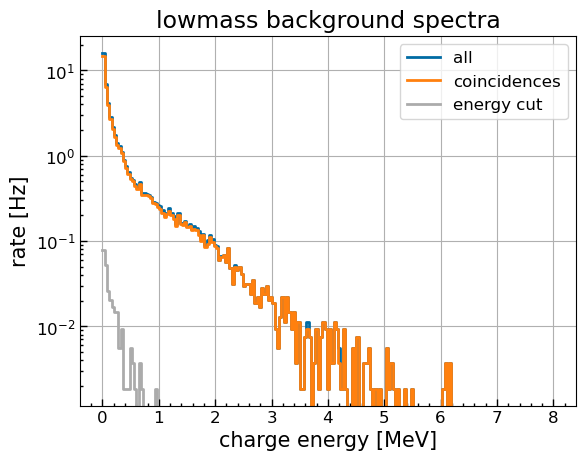

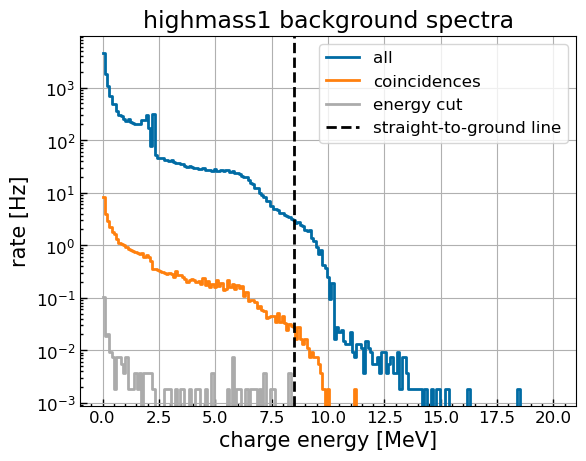

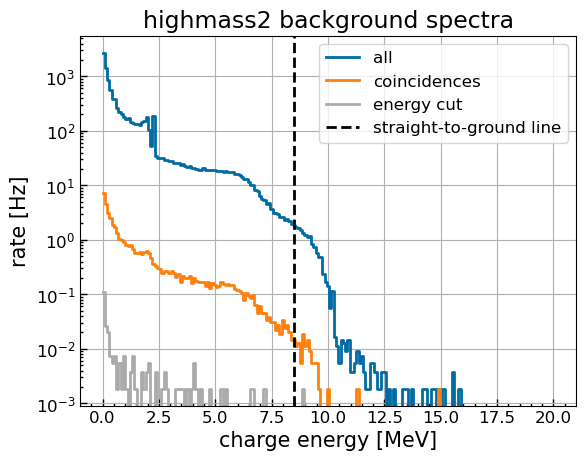

In [308]:
plt.style.use('tableau-colorblind10')
plt.style.use('../figures/style.mplstyle')

# all backgrounds, full range
bin_type = 'full_range'

for det in detectors:

    plt.figure()
    ax = plt.gca()

    ax.set_title(f'{det} background spectra')

    for h in hist_types:
        #label = ' '.join(c.split('_')[1:]) 
        hist = all_hist_dict[h][det][bin_type]
        Ebins = hist['E'].values
        cts = hist[hist.keys()[1]].values
        y = cts/leadrates.meas_exposures[meas]
        #y = df[c].values/leadrates.meas_exposures[meas]
        if h == 'energy_cut':
            h = 'energy cut'
        ax.step(Ebins, y, where = 'post', label = h)


    #ax.step(capcts.Ebins, capcts.cts[det]*capture_rate/capcts.Nprimaries, where = 'post', label = 'postcapture')

    if det in hm:
        plt.axvline(E1, linestyle = 'dashed', color = 'k', label = 'straight-to-ground line')

    if det == 'highmass1':
        window1 = ax.axis()


    ax.semilogy()
    ax.grid()

    ax.legend()
    ax.set_xlabel('charge energy [MeV]')
    ax.set_ylabel('rate [Hz]')



In [260]:
bin_types

('full_range', 'cut_window')

lowmass all 0.9028 +/- 0.0558688 hits/sec/MeV
lowmass coincidences 0.8103 +/- 0.0527169 hits/sec/MeV
lowmass energy_cut 0.0703 +/- 0.00640859 hits/sec/MeV
highmass1 all 30.3585 +/- 0.264799 hits/sec/MeV
highmass1 coincidences 0.289063 +/- 0.0241432 hits/sec/MeV
highmass1 energy_cut 0.041625 +/- 0.00327037 hits/sec/MeV
highmass2 all 19.0758 +/- 0.209827 hits/sec/MeV
highmass2 coincidences 0.189625 +/- 0.0187868 hits/sec/MeV
highmass2 energy_cut 0.0393125 +/- 0.0023125 hits/sec/MeV


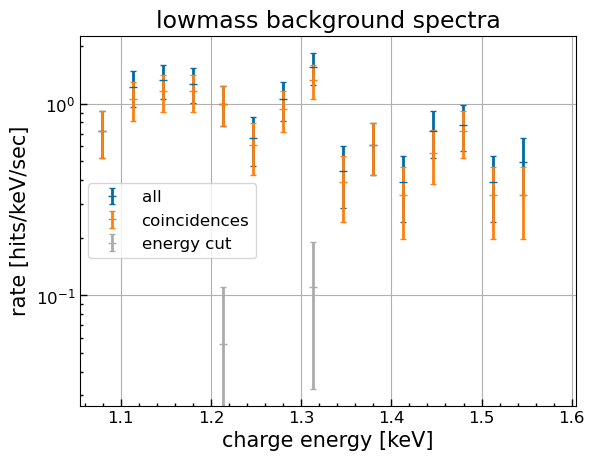

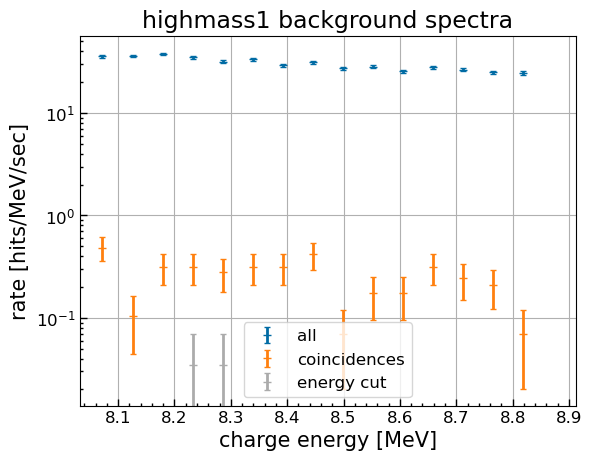

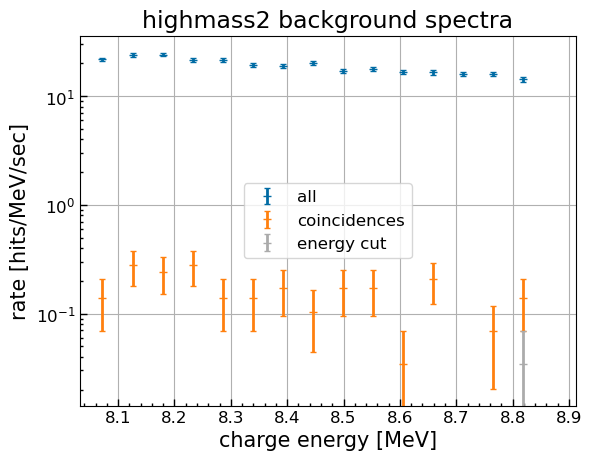

In [ ]:
bin_type = 'cut_window'
for det in detectors:

    if det == 'lowmass':
        k = 1e3
        eu = 'keV'
    else:
        k = 1
        eu = 'MeV'


    plt.figure()
    ax = plt.gca()

    ax.set_title(f'{det} background spectra')
    #Ebins = df4['E'].values
    #dE = (Ebins[1:] - Ebins[:-1]).mean()


    #for c in df4.columns[1:]:
    for h in hist_types:
        hist = all_hist_dict[h][det][bin_type]
        Ebins = hist['E'].values*k
        dE = (Ebins[1:] - Ebins[:-1]).mean()
        cts = hist[hist.keys()[1]].values
        y = cts/leadrates.meas_exposures[meas]/dE
        dy = np.sqrt(cts)/leadrates.meas_exposures[meas]/dE
        lable = hist.keys()[1].split('_')[1] + (' cut' if 'energy' in hist.keys()[1] else '')
        #ax.step(Ebins, y, where = 'post', label = c)
        ax.errorbar(Ebins, y, yerr = dy, label = lable, linestyle = '', marker = '_', capsize = 2)

        print(det, h, f'{(cts+1).sum()/exposure/(Ebins[-1]-Ebins[0]):.6g} +/- {np.sqrt(cts.sum())/exposure/(Ebins[-1]-Ebins[0]):.6g}', 'hits/sec/MeV')

    if 0: # plot expected capture spectrum
        dEcap = np.diff(capcts2.Ebins).mean()
        capy = capcts2.cts[det]*capture_rate/capcts2.Nprimaries/dEcap
        dcapy = np.sqrt(capcts2.cts[det])*capture_rate/capcts2.Nprimaries/dEcap
        
        ax.errorbar(capcts2.Ebins, capy, yerr = dcapy, label = 'postcapture signal', linestyle = '', marker = '_', capsize = 0)

    #plt.axvline(E1, linestyle = 'dashed', color = 'gray', label = 'straight-to-ground')

    ax.semilogy()
    ax.grid()
    #ax.legend(loc = 'lower right')
    ax.legend()
    ax.set_xlabel(f'charge energy [{eu}]')
    ax.set_ylabel(f'rate [hits/{eu}/sec]')

    if det == 'highmass1':
        window2 = ax.axis()
    elif det == 'lowmass':
        plt.savefig('../figures/sim_lm_zoomed_spectra.pdf')


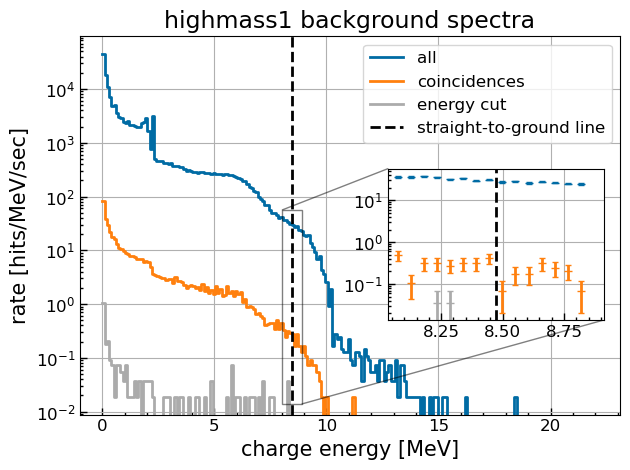

In [317]:
plt.style.use('tableau-colorblind10')
plt.style.use('../figures/style.mplstyle')

# all backgrounds, full range
bin_type = 'full_range'

det = 'highmass1'

fig = plt.figure()
ax = plt.gca()

ax.set_title(f'{det} background spectra')

for h in hist_types:
    #label = ' '.join(c.split('_')[1:]) 
    hist = all_hist_dict[h][det][bin_type]
    Ebins = hist['E'].values
    dE = (Ebins[1:] - Ebins[:-1])
    cts = hist[hist.keys()[1]].values
    y = cts/leadrates.meas_exposures[meas]
    y[:-1] /= dE
    #y = df[c].values/leadrates.meas_exposures[meas]
    if h == 'energy_cut':
        h = 'energy cut'
    ax.step(Ebins, y, where = 'post', label = h)


#ax.step(capcts.Ebins, capcts.cts[det]*capture_rate/capcts.Nprimaries, where = 'post', label = 'postcapture')

plt.axvline(E1, linestyle = 'dashed', color = 'k', label = 'straight-to-ground line')


ax.semilogy()
ax.grid()
window = ax.axis()
ax.set_xlim(window1[0], 1.1*window1[1])

ax.legend()
ax.set_xlabel('charge energy [MeV]')
ax.set_ylabel('rate [hits/MeV/sec]')

Ebins_cut = all_hist_dict['energy_cut'][det]['cut_window']['E'].values

ax2 = ax.inset_axes([0.57, 0.25, 0.4, 0.4], xlim = (window2[0], window2[1]), ylim = (window2[2], window2[3]))


for h in hist_types:
    hist = all_hist_dict[h][det]['cut_window']
    Ebins = hist['E'].values
    dE = (Ebins[1:] - Ebins[:-1]).mean()
    cts = hist[hist.keys()[1]].values
    y = cts/leadrates.meas_exposures[meas]/dE
    dy = np.sqrt(cts)/leadrates.meas_exposures[meas]/dE
    lable = hist.keys()[1].split('_')[1] + (' cut' if 'energy' in hist.keys()[1] else '')
    #ax2.step(Ebins, y, where = 'post', label = c)
    ax2.errorbar(Ebins, y, yerr = dy, label = lable, linestyle = '', marker = '_', capsize = 2)

    #print(det, h, f'{(cts+1).sum()/exposure/(Ebins[-1]-Ebins[0]):.6g} +/- {np.sqrt(cts.sum())/exposure/(Ebins[-1]-Ebins[0]):.6g}', 'hits/sec/MeV')

ax2.axvline(E1, linestyle = 'dashed', color = 'k')

ax2.semilogy()
ax2.grid()
#ax2.set_xlabel(f'charge energy [{eu}]')
#ax2.set_ylabel(f'rate [hits/{eu}/sec]')
ax.indicate_inset_zoom(ax2, edgecolor="black")

fig.tight_layout()
plt.savefig('../figures/sim_hm1_spectra.pdf')

In [262]:
for h in hist_types:
    for bin_type in bin_types:
        for det in detectors:
            hist = all_hist_dict[h][det][bin_type]
            Es = hist['E'].values
            count = sum(hist[hist.keys()[1]].values)
            dcount = np.sqrt(count)
            rate = count/(Es.max() - Es.min())/exposure
            drate = dcount/(Es.max() - Es.min())/exposure
            print(h, bin_type, det, f'{rate} +/- {drate:.5g}', 'hits/sec/MeV')

all full_range lowmass 6.310582038823021 +/- 0.038201 hits/sec/MeV
all full_range highmass1 735.8954769774159 +/- 0.2609 hits/sec/MeV
all full_range highmass2 500.15795578980004 +/- 0.21509 hits/sec/MeV
all cut_window lowmass 843.6000000000355 +/- 55.869 hits/sec/MeV
all cut_window highmass1 30.32150000000125 +/- 0.2648 hits/sec/MeV
all cut_window highmass2 19.038812500000784 +/- 0.20983 hits/sec/MeV
coincidences full_range lowmass 5.8892444861558095 +/- 0.036904 hits/sec/MeV
coincidences full_range highmass1 2.2120560602803945 +/- 0.014304 hits/sec/MeV
coincidences full_range highmass2 2.09846549232755 +/- 0.013932 hits/sec/MeV
coincidences cut_window lowmass 751.1000000000316 +/- 52.717 hits/sec/MeV
coincidences cut_window highmass1 0.2520625000000104 +/- 0.024143 hits/sec/MeV
coincidences cut_window highmass2 0.15262500000000628 +/- 0.018787 hits/sec/MeV
energy_cut full_range lowmass 0.03260625407578314 +/- 0.0027459 hits/sec/MeV
energy_cut full_range highmass1 0.014060070300352093 

In [263]:
# background in highmass1 including uncertainty (low statistics)
h = 'energy_cut'
det = 'highmass1'
bin_type = 'cut_window'
hist = all_hist_dict[h][det][bin_type]
Es = hist['E'].values
count = sum(hist[hist.keys()[1]].values)
rate = count/(Es.max() - Es.min())/exposure
print(det, h, bin_type, rate, 'hits/sec/MeV')

highmass1 energy_cut cut_window 0.004625000000000191 hits/sec/MeV


In [264]:
# total event rate in highmass1
h = 'all'
det = 'highmass1'
bin_type = 'full_range'
hist = all_hist_dict[h][det][bin_type]
Es = hist['E'].values
cts = hist[hist.keys()[1]].values
count = sum(cts[Es > 0.1])
rate = count/exposure
print(det, h, bin_type, rate, 'hits/sec above 100 keV')

highmass1 all full_range 10126.713150000427 hits/sec above 100 keV


In [265]:
for h in hist_types:
    det = 'highmass1'
    bin_type = 'full_range'
    hist = all_hist_dict[h][det][bin_type]
    Es = hist['E'].values
    cts = hist[hist.keys()[1]].values
    count = sum(cts[Es > 0.1])
    rate = count/exposure
    print(det, h, bin_type, rate, 'hits/sec above 100 keV')

highmass1 all full_range 10126.713150000427 hits/sec above 100 keV
highmass1 coincidences full_range 35.941800000001514 hits/sec above 100 keV
highmass1 energy_cut full_range 0.1757500000000074 hits/sec above 100 keV


In [315]:
det = 'highmass1'
print(det)
for h in hist_types:
    bin_type = 'full_range'
    hist = all_hist_dict[h][det][bin_type]
    Es = hist['E'].values
    cts = hist[hist.keys()[1]].values
    count = sum(cts[Es > 0.1])
    rate_100 = count/exposure
    drate_100 = np.sqrt(count)/exposure 

    bin_type = 'cut_window'
    hist = all_hist_dict[h][det][bin_type]
    Es = hist['E'].values
    cts = hist[hist.keys()[1]].values
    count = sum(cts[Es > 0.])
    rate_cut = count/exposure 
    drate_cut = np.sqrt(count)/exposure 
    fixh = 'energy cut' if '_' in h else h

    print(8*' ' + f'{fixh} & ${rate_100:.4g}\\pm{drate_100:.2g}$\\,Hz & ${rate_cut:.4g}\pm{drate_cut:.2g}$\\,Hz \\\\')
    print(8*' ' + '\\hline')

highmass1
        all & $1.013e+04\pm4.3$\,Hz & $24.26\pm0.21$\,Hz \\
        \hline
        coincidences & $35.94\pm0.26$\,Hz & $0.2017\pm0.019$\,Hz \\
        \hline
        energy cut & $0.1758\pm0.018$\,Hz & $0.0037\pm0.0026$\,Hz \\
        \hline


In [267]:
h = 'energy_cut'
det = 'lowmass'
bin_type = 'cut_window'
hist = all_hist_dict[h][det][bin_type]
Es = hist['E'].values
count = sum(hist[hist.keys()[1]].values)
rate = count/exposure/(Es.max() - Es.min())
print(det, h, bin_type, rate, 'hits/sec/MeV')
# 953 coincidences, 125 energy_cut

lowmass energy_cut cut_window 11.100000000000467 hits/sec/MeV


In [268]:
exposure

540.5405405405178

In [269]:
2/37

0.05405405405405406

In [318]:
shift = 0
det = 'lowmass'
bin_type = 'cut_window'
print(det, bin_type)
for h in hist_types: 
    hist = all_hist_dict[h][det][bin_type]
    Es = hist['E'].values
    count = sum((hist[hist.keys()[1]].values+shift))
    dcount = np.sqrt(count)
    rate = count/(Es.max() - Es.min())/exposure
    drate = dcount/(Es.max() - Es.min())/exposure
    print(h, det, f'{rate:.7g} +/- {drate:.5g}', 'hits/sec/MeV')

print('---')

for h in hist_types: 
    hist = all_hist_dict[h][det][bin_type]
    Es = hist['E'].values
    count = sum((hist[hist.keys()[1]].values+shift))
    dcount = np.sqrt(count)
    rate = count/exposure
    drate = dcount/exposure
    print(h, det, f'{rate:.7g} +/- {drate:.5g}', 'hits/sec')

n = 0
print(f'---\n{n} events:', n/exposure, 'hits/sec', n/(Es.max() - Es.min())/exposure, 'hits/sec/MeV')

lowmass cut_window
all lowmass 843.6 +/- 55.869 hits/sec/MeV
coincidences lowmass 751.1 +/- 52.717 hits/sec/MeV
energy_cut lowmass 11.1 +/- 6.4086 hits/sec/MeV
---
all lowmass 0.4218 +/- 0.027934 hits/sec
coincidences lowmass 0.37555 +/- 0.026358 hits/sec
energy_cut lowmass 0.00555 +/- 0.0032043 hits/sec
---
0 events: 0.0 hits/sec 0.0 hits/sec/MeV


In [271]:
shift = 0
bin_type = 'cut_window'
h = 'energy_cut'

for det in ('highmass1', 'lowmass'):
    hist = all_hist_dict[h][det][bin_type]
    Es = hist['E'].values
    count = sum((hist[hist.keys()[1]].values+shift))
    dcount = np.sqrt(count)
    rate = count/(Es.max() - Es.min())/exposure
    drate = dcount/(Es.max() - Es.min())/exposure
    print(h, det, f'{rate:.7g} +/- {drate:.5g}', 'hits/sec/MeV')

    hist = all_hist_dict[h][det][bin_type]
    Es = hist['E'].values
    count = sum((hist[hist.keys()[1]].values+shift))
    dcount = np.sqrt(count)
    rate = count/exposure
    drate = dcount/exposure
    #print(h, det, f'{rate:.7g} +/- {drate:.5g}', 'hits/sec')


energy_cut highmass1 0.004625 +/- 0.0032704 hits/sec/MeV
energy_cut lowmass 11.1 +/- 6.4086 hits/sec/MeV


In [272]:
# lowmass: 932 - 848 - 20
# highmass1: 
det = 'lowmass'
bin_type = 'cut_window'
print(det, bin_type)

for h in hist_types: 
    hist = all_hist_dict[h][det][bin_type]
    Es = hist['E'].values
    count = sum((hist[hist.keys()[1]].values))
    dcount = np.sqrt(count)
    rate = count/exposure
    drate = dcount/exposure
    print(h, det, f'{rate:.10g} +/- {drate:.5g}', 'hits/sec')

n = 2
print(f'---\n{n} events:', n/exposure, 'hits/sec', n/(Es.max() - Es.min())/exposure, 'hits/sec/MeV')

lowmass cut_window
all lowmass 0.4218 +/- 0.027934 hits/sec
coincidences lowmass 0.37555 +/- 0.026358 hits/sec
energy_cut lowmass 0.00555 +/- 0.0032043 hits/sec
---
2 events: 0.003700000000000156 hits/sec 7.400000000000311 hits/sec/MeV


In [273]:
# lowmass: 921 - 821 - 11
# highmass1: 
for h in hist_types: 
    det = 'lowmass'
    bin_type = 'cut_window'
    hist = all_hist_dict[h][det][bin_type]
    Es = hist['E'].values
    count = sum(hist[hist.keys()[1]].values+1)
    dcount = np.sqrt(count)
    rate = count/exposure
    drate = dcount/exposure
    print(h, bin_type, det, f'{rate} +/- {drate:.5g}', 'hits/sec')

all cut_window lowmass 0.451400000000019 +/- 0.028898 hits/sec
coincidences cut_window lowmass 0.40515000000001705 +/- 0.027377 hits/sec
energy_cut cut_window lowmass 0.03515000000000148 +/- 0.008064 hits/sec


In [274]:
len(Es)

16

In [275]:
Es.min(), Es.max()

(0.001079660920468643, 0.001579660920468643)

In [276]:
for det in detectors:
    hist = all_hist_dict['energy_cut'][det]['cut_window']
    Es = hist['E'].values
    print(det, Es[0]*1e3, 'to', Es[-1]*1e3, 'keV')

lowmass 1.079660920468643 to 1.579660920468643 keV
highmass1 8072.2703390798415 to 8872.270339079842 keV
highmass2 8072.2703390798415 to 8872.270339079842 keV


In [277]:
E_tot, E1, E1_lm*1e3

(8.4736, 8.472270339079842, 1.329660920468643)

In [278]:
# "candidate" events
filenames = ['../build/rate_data/Lead20.000000_PE1.000000_20250322_142448_t1.root', '../build/rate_data/Lead20.000000_PE1.000000_20250324_191616_t6.root', '../build/rate_data/Lead20.000000_PE1.000000_20250324_123308_t3.root']

evt_nums = [20017245, 61269647, 16882515]
energies = {det: np.zeros(len(evt_nums)) for det in detectors}

for i, (f, evt) in enumerate(zip(filenames, evt_nums)):

    tfile = ROOT.TFile.Open(f, 'READ')
    tree = tfile.Get('tree')

    last_event = -1
    energy = {det: 0. for det in detectors}

    for k in range(tree.GetEntries()):
        tree.GetEntry(k)

        EventNum = int(getattr(tree, 'EventNum'))

        if EventNum == evt:
            TrkNum = int(getattr(tree, 'TrkNum'))
            Edep = float(getattr(tree, 'Edep'))
            VolName = getattr(tree, 'VolName')
            PName = getattr(tree, 'PName')
            ProcName = getattr(tree, 'ProcName')
            ParentVol = getattr(tree, 'ParentVol')
            IsCapture = bool(int(getattr(tree, 'IsCapture')))
            KE = float(getattr(tree, 'KE'))
            KE3 = float(getattr(tree, 'KE3'))
            DepProc = getattr(tree, 'DepProc')
            Time = float(getattr(tree, 'Time'))
            X = float(getattr(tree, 'X'))
            Y = float(getattr(tree, 'Y'))
            Z = float(getattr(tree, 'Z'))

            energies[VolName][i] += Edep


tfile.Close()

energies = pd.DataFrame.from_dict(energies)

In [279]:
for bin_type in bin_types:
    hist = all_hist_dict['energy_cut']['highmass1'][bin_type]
    Es = hist['E'].values
    print(bin_type, Es[0]*1e3, 'to', Es[-1]*1e3, 'keV')

full_range 0.1 to 20000.0 keV
cut_window 8072.2703390798415 to 8872.270339079842 keV


In [280]:
energies

,lowmass,highmass1,highmass2
0,0.001316,8.305470,0.000000
1,0.001334,0.079510,8.869323
2,0.001243,8.261916,0.533144


In [281]:
energies.sum(axis = 1)

0    8.306785
1    8.950167
2    8.796303
dtype: float64

In [282]:
E1 + E1_lm

8.47360000000031

In [283]:

def get_time_spreads(rates, Nfiles = -1):
    """
    rates - BackgroundRates object

    return histogram of time spreads (time between first and last hit in a detector)
    """

    # recoil types

    lm = 'lowmass'
    hm1 = 'highmass1'
    hm2 = 'highmass2'
    detectors = (lm, hm1, hm2)
    hm = (hm1, hm2)

    # energy bins (MeV)
    tmax = {det: 0 for det in detectors}
    tinfo = {det: None for det in detectors}

    Nbins = 200

    tbins = np.geomspace(1e-9, 1e21, Nbins+1)#{det: np.linspace(0, 10, Nbins+1) for det in detectors}
    
    ROOT.TH1.AddDirectory(False)

    hists = {}

    for det in detectors:
        hists[det] = ROOT.TH1D(det, det, Nbins, tbins)
    
    if Nfiles == -1 or Nfiles > rates.N:
        Nfiles = rates.N

    for i in tqdm.trange(Nfiles):

        measi = rates.measurements[i]

        tfile = ROOT.TFile.Open(rates.glob_list[i], 'READ')
        tree = tfile.Get('tree')

        last_event = -1
        t1 = {det: np.inf for det in detectors}
        t2 = {det: -1 for det in detectors}
        energy = {det: 0 for det in detectors}

        for k in range(tree.GetEntries()):
            tree.GetEntry(k)

            EventNum = int(getattr(tree, 'EventNum'))
            #TrkNum = int(getattr(tree, 'TrkNum'))
            Edep = float(getattr(tree, 'Edep'))
            VolName = getattr(tree, 'VolName')
            #PName = getattr(tree, 'PName')
            #ProcName = getattr(tree, 'ProcName')
            #ParentVol = getattr(tree, 'ParentVol')
            #IsCapture = bool(int(getattr(tree, 'IsCapture')))
            #KE = float(getattr(tree, 'KE'))
            #KE3 = float(getattr(tree, 'KE3'))
            #DepProc = getattr(tree, 'DepProc')
            Time = float(getattr(tree, 'Time'))
            #X = float(getattr(tree, 'X'))
            #Y = float(getattr(tree, 'Y'))
            #Z = float(getattr(tree, 'Z'))

            if abs(EventNum - last_event) > 1e-6: # new event

                # process previous event
                for det in detectors:
                    if energy[det] > 0:
                        dt = t2[det]-t1[det]
                        hists[det].Fill(dt)

                        if dt > tmax[det]:
                            tmax[det] = dt
                            tinfo[det] = (i, last_event)
                                        
                        

                t1 = {det: np.inf for det in detectors}
                t2 = {det: -1 for det in detectors}
                last_event = EventNum


            # accumulate info from this event
            if Edep > 0:
                energy[VolName] += Edep
                if Time < t1[VolName]:
                    t1[VolName] = Time
                if Time > t2[VolName]:
                    t2[VolName] = Time
            
            # end of loop over tree

        tfile.Close()
        # end of loop over files

    # convert ROOT TH1D's into dataframes

    df_dict = {'t': tbins}

    for det in detectors:
        cts = np.zeros(Nbins+1)
        h = hists[det]
        for i in range(1, Nbins+1):
            cts[i-1] = h.GetBinContent(i)

        df_dict[det] = cts
                

    return pd.DataFrame.from_dict(df_dict), tmax, tinfo




In [284]:
tdf, tmax, tinfo = get_time_spreads(leadrates, -1)

  3%|▎         | 48/1600 [00:36<19:34,  1.32it/s]


KeyboardInterrupt: 

In [ ]:
tmax

{'lowmass': 232225647719768.0,
 'highmass1': 1.1245751969070703e+20,
 'highmass2': 3.449701874006522e+19}

In [ ]:
tinfo

{'lowmass': (302, 54449445),
 'highmass1': (661, 35319206),
 'highmass2': (262, 78963305)}

In [ ]:
leadrates.glob_list[3]

'../build/rate_data/Lead20.000000_PE1.000000_20250315_183533_t0.root'

lowmass 337.0 17.0 0.050445103857566766
highmass1 2781614.0 885808.0 0.31845108631176
highmass2 1640055.0 535427.0 0.3264689293956605


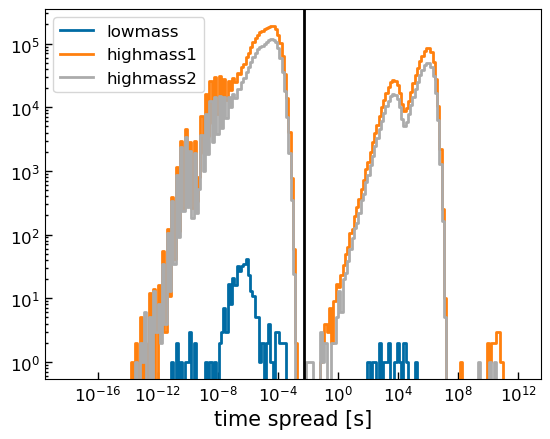

In [ ]:

plt.figure()

tbins = tdf['t'].values/1e9
for det in detectors:
    plt.step(tbins, tdf[det].values, label = det)

plt.legend()
plt.loglog()
plt.xlabel('time spread [s]')

idx = 105

plt.axvline(tbins[idx], color = 'k')

for det in detectors:
    R1 = sum(tdf[det].values[:idx])
    R2 = sum(tdf[det].values[idx:])
    print(det, R1, R2, R2/R1)
